## Point Cloud/DEM Alignment [In-progress, please be patient]
#### Adapted from the [ASP Documentation](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html#pc-align)

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import requests
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from distutils.spawn import find_executable
import dask
import zipfile
from pyproj import Proj, transform
import subprocess
import asp_binder_utils as asp_utils
import xyzservices
import rioxarray
import rasterio

### Universal settings

In [14]:
#verbose = False #  Will only print the bash commands and whether the process ran sucessfully or not
verbose = True # will print all the logs printed by ASP
alignment_algortihm = 'point-to-plane' # suggested to use point-to-point if the terrain variability is low (more flat terrain cases)
max_displacement = 50 #you might have to play with this to adapt to different datasets
tsrs = 'EPSG:32610' # inpute projection
tr = 30 #DEM resolution

### Download DEMs to perform registration
* For the purpose of this tutorial, we will register the ASTER DEM produced using the stereo processing tutorial to the Copernicus GLO-30 DEM.
    * To run this tutorial without running the stereo processing tutorial, we have archived the ASTER DEM produced using the ASTER camera models and orthorectified imagery (Type 3) on [Zenodo](https://zenodo.org/records/10208419). We will fetch it directly from zenodo.

* Alternatively, users can bring their own DEMs, and explore the tutorial using the same! Please follow the below guidelines to do so.
    * To perform this in a github codespace session, go to the file explorer on the right, do a right click and select upload, then upload the DEMs of your choice from the file browser.
    * See also this [stack exhange answer](https://stackoverflow.com/questions/62284623/how-can-i-upload-a-file-to-a-github-codespaces-environment)

* When you change the DEMs to a different site than the site used by default, make sure to change the projected corrdinate system definition (t_srs) 

### Download ASTER ASP DEM over Mt. Rainier

In [5]:
aster_dem_fn = 'aster_orthorectified-DEM.tif'
#ASTER Sample has been staged on Zenodo:
#https://zenodo.org/record/7972223/files/AST_L1A_00307312017190728_20200218153629_19952.zip?download=1
zenodo_url = 'https://zenodo.org/records/10208419/files/aster_orthorectified-DEM.tif?download=1'
if os.path.exists(aster_dem_fn):
    print(f"file {aster_dem_fn} already downloaded")
else:
    response = requests.get(zenodo_url)
    #Check for 200
    if response.ok:
        print ('OK!')
    else:
        print ('Query failed')
        sys.exit()
    #Write to disk
    open(aster_dem_fn, 'wb').write(response.content)
    print(f"file {aster_dem_fn} saved")

OK!
file aster_orthorectified-DEM.tif saved


### Download Copernicus DEM over a similar extent

In [7]:

# get aoi extent in geographic coordinates
aoi_extent = asp_utils.subsetBBox(aster_dem_fn,'EPSG:4326')
#in_crs = rasterio.open(dem_file).crs

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/workspaces/asp_tutorials/tutorials/asp_binder_utils.py:108: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
 

In [10]:
opentopo_api_key = 'demoapikeyot2022' #paste your open topography api key within the quotes
reference_cop30 = asp_utils.get_dem('COP30',aoi_extent,apikey=opentopo_api_key,proj=tsrs)
reference_cop30

https://portal.opentopography.org/API/globaldem?demtype=COP30&west=-122.3432849411124&south=46.72248482449153&east=-121.35468538023632&north=47.32888038665895&outputFormat=GTiff&API_Key=demoapikeyot2022
OK!
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -tr 30 30 -t_srs 'EPSG:32610' COP30.tif COP30_proj.tif
/srv/conda/envs/notebook/bin/gdalwarp -r cubic -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=IF_SAFER -tr 30 30 -t_srs 'EPSG:32610' COP30.tif COP30_proj.tif


Child returned 0


'COP30_proj.tif'

## Perform Co-registration

In [12]:
pc_align = find_executable('pc_align')
refdem = reference_cop30
src_dem = aster_dem_fn
alignment_dir  = 'alignment/aster_aligned2COP30'
alignment_call = f'{pc_align} --highest-accuracy  --save-transformed-source-points --alignment-method {alignment_algortihm}  --max-displacement {max_displacement} {refdem} {src_dem} -o {alignment_dir}'
asp_utils.run_bash_command(alignment_call,verbose=verbose)

/srv/StereoPipeline/bin/pc_align --highest-accuracy  --save-transformed-source-points --alignment-method point-to-plane  --max-displacement 50 COP30_proj.tif aster_orthorectified-DEM.tif -o alignment/aster_aligned2COP30
	--> Setting number of processing threads to: 4

Creating output directory: "alignment".
Writing log info to: alignment/aster_aligned2COP30-log-pc_align-11-27-0609-28559.txt
Detected datum from COP30_proj.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-122.351, 46.712) width: 1.01623 height: 0.627589)
Source box:    (O

writing to alignment/aster_aligned2COP30-iterationInfo.csv


Match ratio: 0.75001
Alignment took 2.06491 [s]
Number of errors: 100000
Output: error percentile of smallest errors (meters): 16%: 1.93518, 50%: 6.82568, 84%: 14.9667
Output: mean of smallest errors (meters): 25%: 1.52179, 50%: 3.20503, 75%: 5.22119, 100%: 8.40389
Final error computation took 0.177086 [s]
Alignment transform (origin is planet center):
     0.999999997641995  6.039195928674014e-05 -3.269282216974078e-05      363.6611980162561
-6.038956174757597e-05     0.9999999954878057  7.333135756929653e-05     -509.4850589320995
 3.269725064658374e-05 -7.332938309115579e-05     0.9999999967768455     -188.7272712606937
                     0                      0                      0                      1
Centroid of source points (Cartesian, meters): Vector3(-2299901.9,-3699208.3,4644563.2)
Centroid of source points (lat,lon,z): Vector3(47.029056,-121.87038,814.58773)

Translation vector (Cartesian, meters): Vector3(-11.579694,-29.986177,7.3179526)
Translation vector (North-Ea

Child returned 0


In [16]:
### Tada: we have the aligned pointcloud. Note the log printed above for some important observations, such as: input and output error statistics, Translation vector (North-East-Down, meter) etc
## The output is in ASP 4-band point cloud tiff file. We will need to re-grid it to generate the aligned source DEM.
## Recall the point2dem gridding call in the stereo processing tutorial
point2dem = find_executable('point2dem')
tr = tr
tsrs = tsrs
#p2dem_args = '--errorimage'
pointcloud = glob.glob(alignment_dir+'*-trans_source.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f"{point2dem} --tr {tr} --t_srs '{tsrs}' {pointcloud}"
asp_utils.run_bash_command(point2dem_call,verbose=verbose)
aligned_dem = glob.glob(alignment_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(aligned_dem))


Gridding pointcloud alignment/aster_aligned2COP30-trans_source.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32610' alignment/aster_aligned2COP30-trans_source.tif
	--> Setting number of processing threads to: 4
Writing log info to: alignment/aster_aligned2COP30-trans_source-log-point2dem-11-27-0612-29799.txt
The point cloud files must have an equal number of channels which must be 4 or 6 to be able to remove outliers.
Statistics: [********************************************************] Complete!
QuadTree: [**********************************************************] Complete!
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(2461,2284) px.
Writing: alignment/aster_aligned2COP30-trans_source-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels: 73.7999%
DEM saved at alignment/aster_aligned2COP30-trans_source-DEM.tif


Child returned 0


In [17]:
## Visualize the change before and after DEM alignment
refdem_ar = rioxarray.open_rasterio(refdem)
src_dem_ar = rioxarray.open_rasterio(src_dem)
aligned_dem_ar = rioxarray.open_rasterio(aligned_dem)

/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


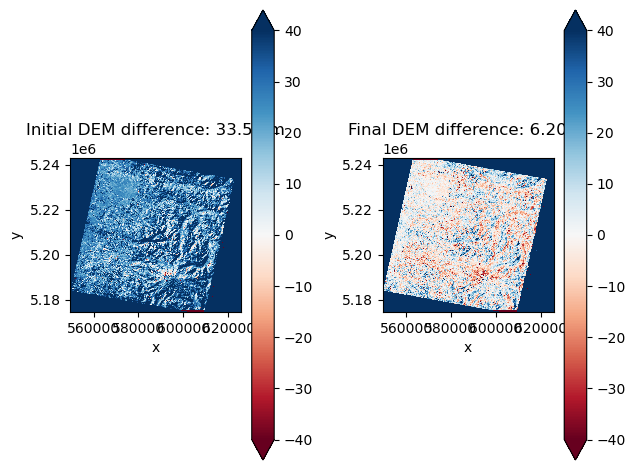

In [26]:
diff = refdem_ar - src_dem_ar.rio.reproject_match(refdem_ar,resampling=rasterio.enums.Resampling.bilinear)
aligned_diff = refdem_ar - aligned_dem_ar.rio.reproject_match(refdem_ar,resampling=rasterio.enums.Resampling.bilinear)
f,ax = plt.subplots(1,2)
clim = (-40,40)
diff.plot(vmin=clim[0], vmax=clim[1], cmap="RdBu",ax=ax[0])
ax[0].set_title(f"Initial DEM difference: {diff.median().item():.2f} m")
aligned_diff.plot(vmin=clim[0], vmax=clim[1], cmap="RdBu",ax=ax[1])
ax[1].set_title(f"Final DEM difference: {aligned_diff.median().item():.2f} m")

for axa in ax.ravel():
    axa.set_aspect('equal')
plt.tight_layout()

# Shashank TODO
* Fix nodata issue
* Fix colorbar length
* Add explanation

## Additional things to keep in mind: 
* Higher resolution DEM/point cloud should be treated as reference in the pc_align call.
* Max displacement should be chosen carefully